# A4 Convolutional Neural Networks

Brent Staab

## Instructions

In this assignment, you will finish writing this new class, named `NeuralNetwork_Convolutional` that uses the `torch.nn` module to construct neural networks with initial convolutional layers followed by fully connected layers to learn to classify images.  Your main job is to finish the `train` function, following steps shown in lecture notes.

The network will have some number, possibly zero, layers of convolutional units having the `tanh` activation function.  These are followed by one or more layers with fully connected units with `tanh` activation functions.

A tricky part of building this structure is determining the correct number of inputs to the first fully-connected layer.  This requires knowing the size of the output image generated by the last convolutional layer.  If this layer produces an output image that is $n\times n$ and it has $m$ units, then the concatenation of all image values for all units into one vector to form the input to the fully-connected layer, the resulting vector will be $m \cdot n^2$.

As an example, say our data contains images that are $d\times d$ and we have a neural network with two convolutional layers and one fully connected layer. 

Original input image: 
- $d\times d$ of $c$ channels

First convolutional layer with $u_1$ units having kernels sized $k_1\times k_1$ and strides of $s_1$
- input is $d\times d$ of $c$ channels
- output is $z_1\times z_1$ of $u_1$ channels, where $z_1 = \frac{d - k_1}{s_1} + 1$

Second convolutional layer with $u_2$ units having kernels sized $k_2\times k_2$ and strides of $s_2$
- input is $z_1\times z_1$ of $u_1$ channels
- output is $z_2\times z_2$ of $u_2$ channels, where $z_2 = \frac{z_1 - k_2}{s_2} + 1$


Third convolutional layer is fully-connected, so we must flatten into a vector the output from the previous convolutional layer. Say this layer has $u_3$ units.
- input is $u_2 \, z_2 ^ 2$
- output is $u_3$ values

## Import code needed in this notebook

In [27]:
import numpy as np
import torch
import time
import copy
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import pickle, gzip

## Definition of `NeuralNetwork_Convolutional`

In [28]:
class NeuralNetwork_Convolutional():
    # Initilization function (a.k.a. constructor) for object
    def __init__(self, 
                 n_channels_in_image,         # (int) number of values per pixel 
                 image_size,                  # (int) number of rows in image, same as number of columns
                 n_units_in_conv_layers,      # (list of ints) number of units in each convolutional layer
                 kernels_size_and_stride,     # (list of lists) each list is [kernel_size, kernel_stride] for each convolutional layer
                 n_units_in_fc_hidden_layers, # (list of ints) number of units in fully-connected layers
                 classes,                     # (list of ints) labels for each class
                 use_gpu=False):              # (boolean) flag indicating GPU use or not (default = no GPU)

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)
      
        # Build the net layers
        self.nnet = torch.nn.Sequential()

        # Add convolutional layers
        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer
                
            self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))
        
        # Define loss and optimizer functions
        self.loss_F = torch.nn.CrossEntropyLoss()
        
        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

        optimizer = torch.optim.Adam(self.nnet.parameters(), lr=self.learning_rate)
        
        # You fill in the rest of the train function, following lecture notes example.
        for epoch in range(n_epochs):
            optimizer.zero_grad()

            Y = self.nnet(X)

            error = self.loss_F(Y, T)
            self.error_trace.append(error)
            if epoch % 5 == 0:
                print(f'Epoch {epoch} error {error:.5f}')

            error.backward()

            optimizer.step()
        
        self.training_time = time.time() - start_time
        
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

## Helper functions

In [71]:
# Helper function to test a speific network configuration
def run_test(nuicl, ksas, unifhl, c, ug, nepoch, lr):
    torch.random.manual_seed(42)
    nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=nuicl,
                                       kernels_size_and_stride=ksas,
                                       n_units_in_fc_hidden_layers=unifhl,
                                       classes=c,
                                       use_gpu=ug)
    nnet.train(Xtrain, Ttrain, nepoch, learning_rate=lr)
    Yclasses, Y = nnet.use(Xtest)
    n_correct = (Yclasses == Ttest).sum()
    
    return [n_correct, Yclasses, nnet.get_error_trace()]

In [86]:
# Helper function to print/plot results
def print_results(results):
    plt.figure(figsize=(25, 8)) 
    plt.title('Error Trace')                                  # Add plot title
    plt.xlabel('epoch')                                       # Add X-axis label
    plt.ylabel('Likelihood')                                  # Add Y-axis label
                                                              #
    index = 0                                                 # Initialize counter variable
    for result in results:                                    # Iterate over each result
        plt.plot(result[2], '-', label=f'Test {index}')       # Add first data set to plot
        print(f'Test {index} - {result[0]} out of {Ttest.shape[0]} samples or {result[0]/Ttest.shape[0]*100:.2f} percent.')
        index += 1                                            # Increment the count
                                                              #
    plt.legend()                                              # Display legend on plot
    plt.grid(True)                                            # Display grid on plot

## Simple Example with Squares and Diamonds

Repeating the example from lecture notes.

In [31]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 1, 20, 20), (1000, 1), (20, 1, 20, 20), (20, 1))

In [32]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5], # , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=[1, 2],
                                   kernels_size_and_stride=[[5, 2]], #conv_kernels=[[5, 2]], # , [4, 1]],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Epoch 0 error 0.69500
Epoch 5 error 0.55628
Epoch 10 error 0.45993
Epoch 15 error 0.36042
Epoch 20 error 0.27575
Epoch 25 error 0.20170
Epoch 30 error 0.14988
Epoch 35 error 0.12010
Epoch 40 error 0.09970
Epoch 45 error 0.08456


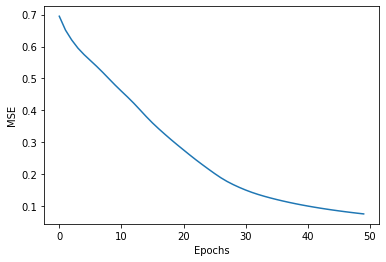

In [33]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [34]:
Yclasses, Y = nnet.use(Xtest)

print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.', end='')
print(f'  Training took {nnet.training_time:.3f} seconds.')

20 out of 20 test samples correctly classified.  Training took 0.451 seconds.


Let's see what the output of the convolutional layer produces, and the weight matrices of each unit that produce those output images.   Here are functions, `show_layer_output` and `show_layer_weights` that will do this for us.

In [35]:
def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

(-0.5, 19.5, 19.5, -0.5)

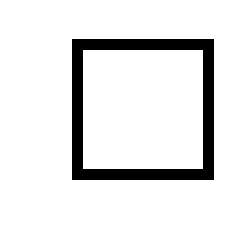

In [36]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

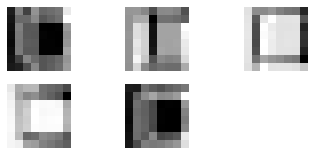

In [37]:
show_layer_output(nnet, X_sample, 0);

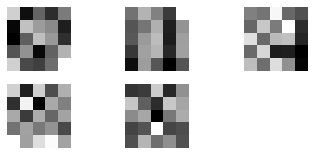

In [38]:
show_layer_weights(nnet, 0);

## MNIST Digits

Investigate the application of your code to the classification of MNIST digits, which you may download from [this site](http://deeplearning.net/tutorial/gettingstarted.html).

In [39]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [40]:
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtrain.shape, Ttrain.shape

((50000, 784), (50000,))

In [41]:
a = Xtrain[0, :].reshape(28, 28)
a.shape

(28, 28)

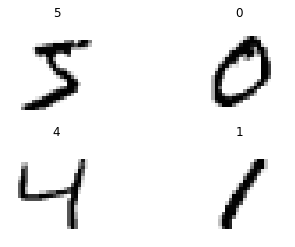

In [42]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28, 28), cmap='binary')
    plt.title(Ttrain[i])
    plt.axis('off');

**Required:** Try different numbers of layers and units, kernel sizes and strides, and learning rates and epochs to get greater than 90% test images correctly classified.  Your grade will only depend on you showing various results, not on achieving this accuracy.

In [43]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [44]:
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshape(-1, 1, 28, 28)
Ttest = test_set[1][testi].reshape(-1, 1)

In [45]:
torch.random.manual_seed(42)
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5, 5],
                                   kernels_size_and_stride=[[5, 3], [4, 2]],
                                   n_units_in_fc_hidden_layers=[10],
                                   classes=[0, 1, 2],
                                   use_gpu=False)

In [46]:
nnet.train(Xtrain, Ttrain, 20, learning_rate=0.01)

Epoch 0 error 1.11647
Epoch 5 error 0.69274
Epoch 10 error 0.31685
Epoch 15 error 0.15003


In [47]:
Yclasses, Y = nnet.use(Xtest)
n_correct = (Yclasses == Ttest).sum()
print(f'{n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

27 out of 30 samples, or 90.00 percent.


## Experiments

Try different numbers of layers and units, kernel sizes and strides, and learning rates and epochs to get greater than 90%  
  
NOTE: The 'run_test' helper function sets the random seed to a specific value.  This is done to to eliminate a variable and allow direct comparison between each test.  Also, the first test of each experiment is the baseline configuration defined in the assignment.  This configuration yields 90% accuracy and seems like a good baseline.

#### Number of layers

In [93]:
%%capture
results = []
results.append(run_test(         [5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(            [5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(      [5, 5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(   [5, 5, 5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5, 5, 5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 28 out of 30 samples or 93.33 percent.
Test 2 - 27 out of 30 samples or 90.00 percent.
Test 3 - 27 out of 30 samples or 90.00 percent.
Test 4 - 27 out of 30 samples or 90.00 percent.


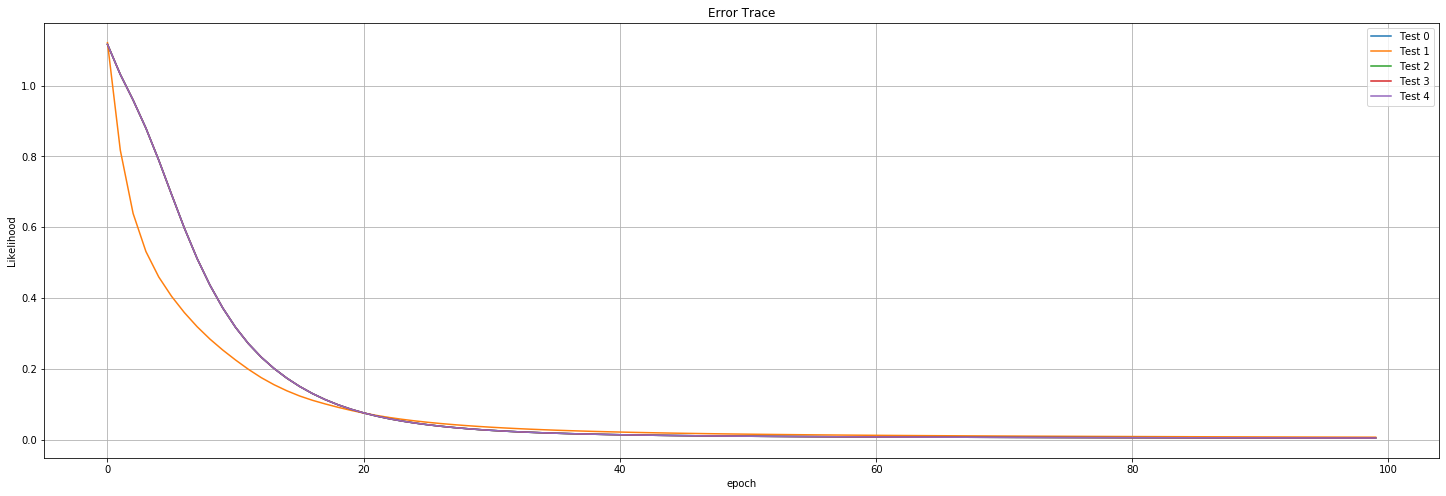

In [94]:
print_results(results)

The network with the fewest number of layers had the best performance.  It was able to correctly identify 93% of the samples while networks with > 1 layer had 90% accuracy.

### Number of units

In [95]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(   [5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(   [1], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(  [10], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(  [50], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test( [500], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 28 out of 30 samples or 93.33 percent.
Test 2 - 29 out of 30 samples or 96.67 percent.
Test 3 - 29 out of 30 samples or 96.67 percent.
Test 4 - 27 out of 30 samples or 90.00 percent.
Test 5 - 25 out of 30 samples or 83.33 percent.


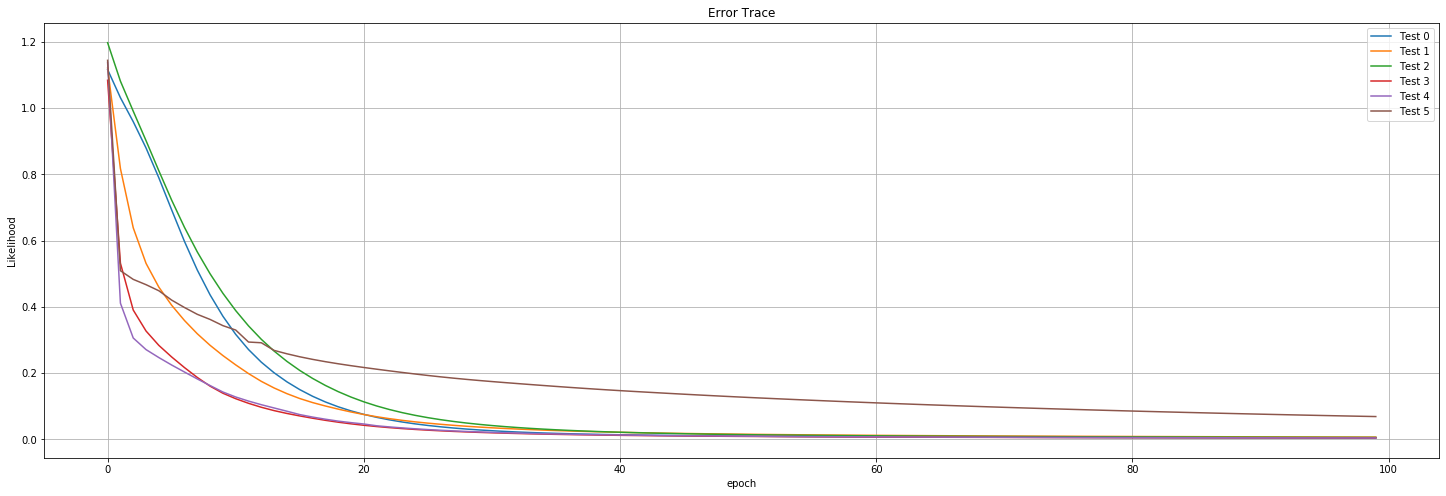

In [96]:
print_results(results)

The results are somewhat mixed.  The best performance (96% accuracy) was seen with one and ten units in the hidden layer while a value in between didn't do a well (93% accuracy).  Once we are beyond ten units, the performance continues to decrease.  The worst performance (83% accuracy) was in the network with the most units.

#### Layers and Units

In [97]:
%%capture
results = []
results.append(run_test(             [5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(                [5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(                [1], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(              [2,2], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(            [3,3,3], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(        [5,5,5,5,5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([50,50,50,50,50,50], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 28 out of 30 samples or 93.33 percent.
Test 2 - 29 out of 30 samples or 96.67 percent.
Test 3 - 27 out of 30 samples or 90.00 percent.
Test 4 - 26 out of 30 samples or 86.67 percent.
Test 5 - 27 out of 30 samples or 90.00 percent.
Test 6 - 26 out of 30 samples or 86.67 percent.


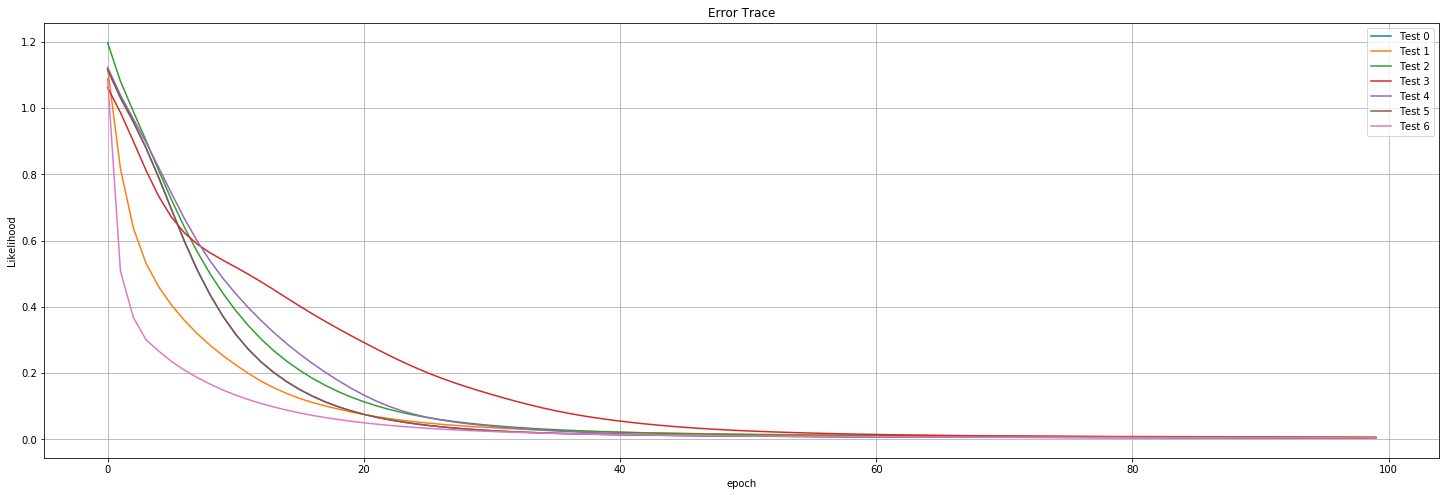

In [98]:
print_results(results)

The results were somewhat mixed.  The performance varies based on the number of layers and units in the layer in non-monotonic way.  The best network configuration had two layers with two units in each layer and was able to correctly identify 96% of the samples.

### Kernel Size and Stride
##### Kernel size (1st layer)

In [87]:
%%capture
results = []
results.append(run_test([5, 5], [ [5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [ [1, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [ [5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[10, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[15, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 28 out of 30 samples or 93.33 percent.
Test 2 - 29 out of 30 samples or 96.67 percent.
Test 3 - 27 out of 30 samples or 90.00 percent.
Test 4 - 26 out of 30 samples or 86.67 percent.
Test 5 - 27 out of 30 samples or 90.00 percent.
Test 6 - 26 out of 30 samples or 86.67 percent.


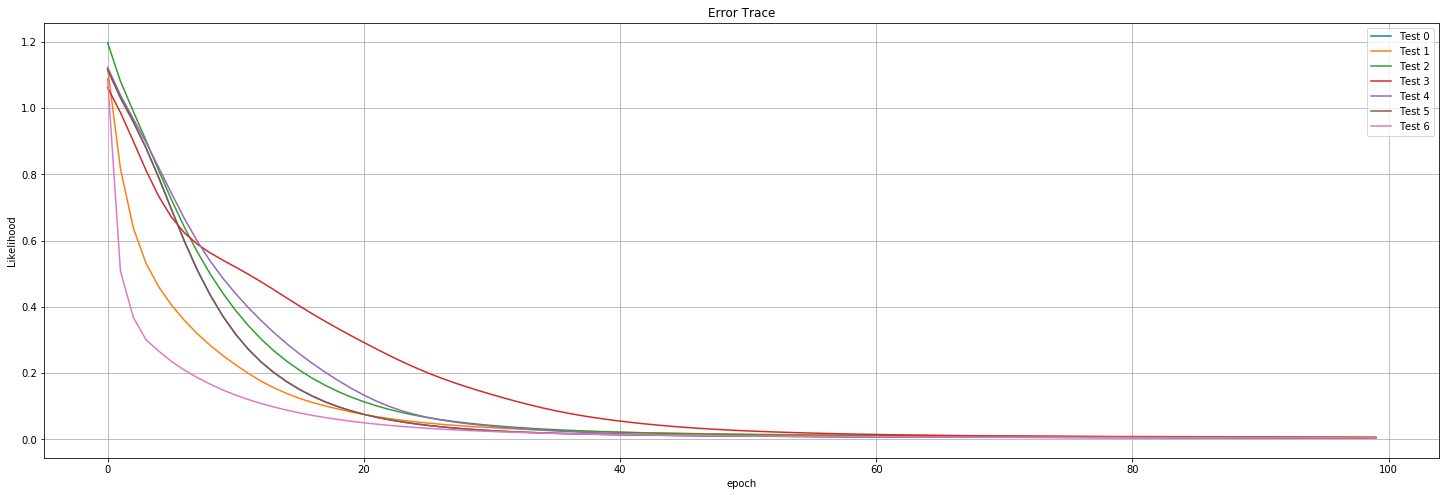

In [99]:
print_results(results)

The performance varies in a non-monotonic way based on the kernel size.  The best overall performance (96% accuracy) was seen on a network with the biggest kernel size (15).

##### Stride size (1st layer)

In [57]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 1], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 2], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 5], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 6], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 26 out of 30 samples or 86.67 percent.
Test 2 - 28 out of 30 samples or 93.33 percent.
Test 3 - 28 out of 30 samples or 93.33 percent.
Test 4 - 27 out of 30 samples or 90.00 percent.


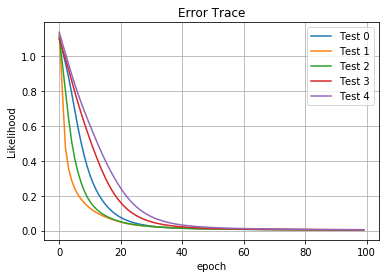

In [58]:
print_results(results)

The best results (93% accuracyc) was observed on a network with a step size of two or five.  The worst performane (86% accuracy) was seen with a step size of one.

#### kernel size and stride (1st layer)

In [59]:
%%capture
results = []
results.append(run_test([5, 5], [ [5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [ [1, 1], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [ [1, 5], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [ [5, 1], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[10, 1], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 29 out of 30 samples or 96.67 percent.
Test 2 - 28 out of 30 samples or 93.33 percent.
Test 3 - 26 out of 30 samples or 86.67 percent.
Test 4 - 29 out of 30 samples or 96.67 percent.


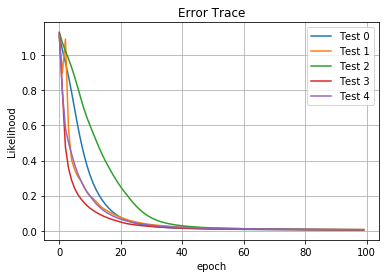

In [60]:
print_results(results)

The best result (96% accuracy) was seen with a kernel size of one or ten and a stride of one.  The worst behavior (86% accuracy) was seen with a kernel size of 5 and stride of one.

#### kernel size and stride (2nd layer)

In [61]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [1, 1]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [1, 5]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [5, 1]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 27 out of 30 samples or 90.00 percent.
Test 2 - 21 out of 30 samples or 70.00 percent.
Test 3 - 29 out of 30 samples or 96.67 percent.


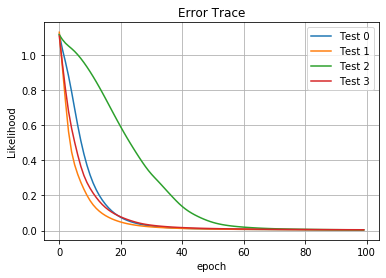

In [62]:
print_results(results)

The best performance (96% accuracy) was seen with a kernel size of five and stride of one.  Interestingly, this combination on the first layer gave the worst overall result in the previous experiment.

#### kernel size and stride (1st & 2nd layer)

In [63]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 1], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [1, 1]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[1, 1], [1, 1]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[3, 1], [3, 1]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 1], [5, 1]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 26 out of 30 samples or 86.67 percent.
Test 2 - 27 out of 30 samples or 90.00 percent.
Test 3 - 10 out of 30 samples or 33.33 percent.
Test 4 - 28 out of 30 samples or 93.33 percent.
Test 5 - 28 out of 30 samples or 93.33 percent.


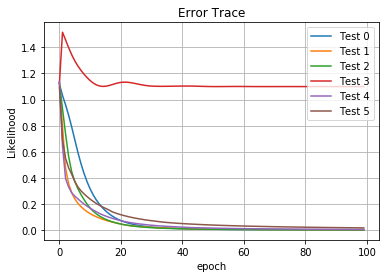

In [64]:
print_results(results)

THe best result (93% accuracy) was seen with a kernel size of three or five and stride of one.  The network with the worst behavior (86% accuracy) was seen with a kernel size of 5 and stride of one in the first layer.  I'm not sure why this is, but is consistent with the previous experiemnt above.

### Learning rate

In [100]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.1))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.2))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.5))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.001))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.001))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 26 out of 30 samples or 86.67 percent.
Test 2 - 27 out of 30 samples or 90.00 percent.
Test 3 - 27 out of 30 samples or 90.00 percent.
Test 4 - 27 out of 30 samples or 90.00 percent.
Test 5 - 27 out of 30 samples or 90.00 percent.


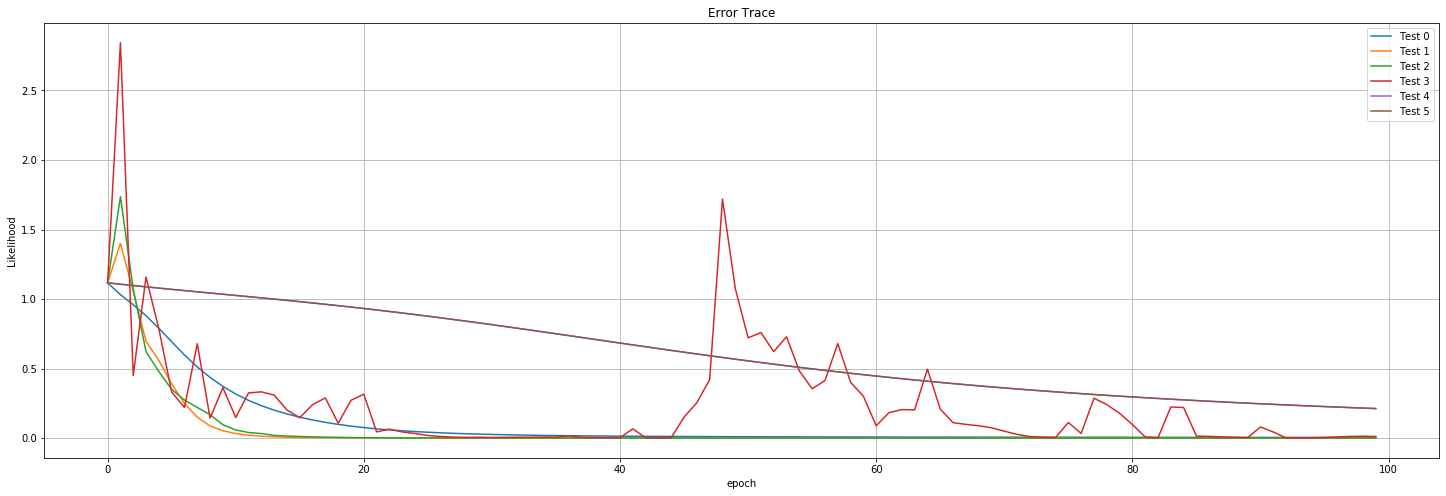

In [101]:
print_results(results)

The learning rate does not appear to have a significant impact on the overall result.  This is most likely due to the number of iterations used train the network.  A smaller number of training cycles would likely make this more pronounced.

### Number of epochs

In [67]:
%%capture
results = []
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   1, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   2, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   3, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   4, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   5, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   6, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   7, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False,   8, 0.01))
results.append(run_test([5, 5], [[5, 3], [4, 2]], [10], [0, 1, 2], False, 10, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 10 out of 30 samples or 33.33 percent.
Test 2 - 16 out of 30 samples or 53.33 percent.
Test 3 - 19 out of 30 samples or 63.33 percent.
Test 4 - 21 out of 30 samples or 70.00 percent.
Test 5 - 22 out of 30 samples or 73.33 percent.
Test 6 - 24 out of 30 samples or 80.00 percent.
Test 7 - 25 out of 30 samples or 83.33 percent.
Test 8 - 27 out of 30 samples or 90.00 percent.
Test 9 - 27 out of 30 samples or 90.00 percent.


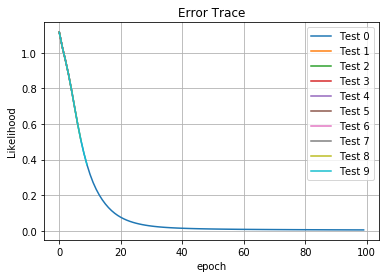

In [68]:
print_results(results)

The number of iterations below 8 makes a significant imipact on the overall performance.  Above 8, the performane plateus at 90% accuracy.

#### all parameters

In [104]:
%%capture
results = []

results.append(run_test(             [5, 5], [ [5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(               [10], [ [5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([50,50,50,50,50,50], [ [5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(             [5, 5], [[10, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(             [5, 5], [ [5, 1], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(             [5, 5], [ [5, 1], [4, 2]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test(             [5, 5], [ [5, 3], [4, 2]], [10], [0, 1, 2], False, 100, 0.1))
results.append(run_test(             [5, 5], [ [3, 1], [3, 1]], [10], [0, 1, 2], False, 100, 0.01))
results.append(run_test([50,50,50,50,50,50], [ [3, 1], [3, 1]], [10], [0, 1, 2], False, 100, 0.01))

Test 0 - 27 out of 30 samples or 90.00 percent.
Test 1 - 29 out of 30 samples or 96.67 percent.
Test 2 - 26 out of 30 samples or 86.67 percent.
Test 3 - 28 out of 30 samples or 93.33 percent.
Test 4 - 26 out of 30 samples or 86.67 percent.
Test 5 - 26 out of 30 samples or 86.67 percent.
Test 6 - 26 out of 30 samples or 86.67 percent.
Test 7 - 28 out of 30 samples or 93.33 percent.
Test 8 - 27 out of 30 samples or 90.00 percent.


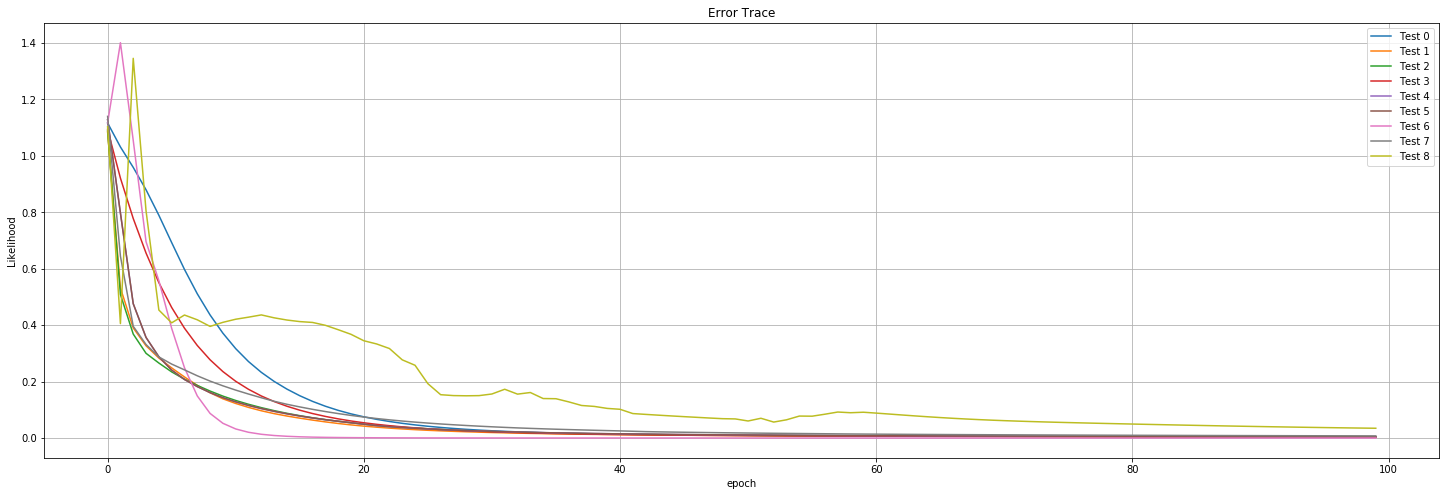

In [105]:
print_results(results)

This is an aggregatioin of the best results from the previous experiments. The best network configuration had a single layer with 10 units, followed by two layers with a kernel size and stride of 5, 3 & 4,2 respetively.  It was trained for one hundred iterations.

## Extra Credit #1

For one of your runs, display the output images of your convolutional layers and the weights for those  layers.  Discuss what you see.  Describe why the displayed weight patterns result in the output images of the first convolutional layer.

## Extra Credit #2

My machine doesn't have a GPU
GPU is not available. Running on CPU.

# Grading

Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.zip) and extract A4grader.py from it. 

In [ ]:
%run -i A4grader.py